# SVM
- SVMアルゴリズムによるクラス分類モデル（SVC）を構築
- グリッドサーチによるハイパーパラメータチューニング
- 各種評価を算出


1. SVMとは
2. データ取得
3. EDA
4. 前処理
5. データセットの分割
6. グリッドサーチ
7. 学習
8. 評価
9. クラス化
10. 今後の課題

## 1. SVMとは

SVM（サポートベクターマシーン）とは、データを分離する線や面を引いて分類する機械学習方法。  
分類と回帰の両方可能であり、局所解収束の問題が無い長所がある。

例えば、2次元の特徴量を持つデータに対し、線形モデルによって2値分類を行うことを考える。  
データがプロットされた平面上に境界線を引いて、2つに分類する際、境界線と最も近いデータをサポートベクターと呼び、汎化能力を高くするため** 境界線とサポートベクターとの距離が最大になるように線を引く。**


- サポートベクターは各クラスに少なくとも1つ存在。
- サポートベクターとの距離の帯のことを** マージン **と呼ぶ。（その真ん中が判別のための境界線）
- この境界線はサポートベクターの位置のみによって決まる。  
つまり、サポートベクター以外のデータの値が変化したり、外れ値が含まれていても、分類に影響はない。
- 新しいデータが入ってきても平均や分散を使わないので全体の再計算は不要。
- 線形分離が不可能な場合は、**非線形変換を施したうえでより高次元特徴空間に写像 **することで対応できる。

### SVMにおけるカーネルとは
元の次元では分離できないデータを高次元に非線形写像するために用いる関数
- RBF（動径基底関数、ガウス関数）
- 多項式
- シグモイド


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_rows = None
pd.options.display.max_columns = None

## 2. データ取得
データセット：UCIのBreast Cancer Wisconsin（Diagnostic）Data Set    
http://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

In [2]:
df = pd.read_csv("input/bcwd.txt",header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


**目的変数**  
- M（malignant）：悪性  
- B（benign）：良性

**説明変数**  
- 乳がんの検査写真を複数枚撮影（特徴量10個）
- それぞれの特徴量の** 平均・標準誤差・大きさや悪性度合上位の平均 **をそれぞれ算出
- 総特徴量30個（10×3）

### 特徴量ラベリング

In [3]:
main_cols = ['radius','texture','perimeter','area','smoothness','compactness','concavity','concave_points','symmetry','fractal_dimension']
sub_cols = ['_m','_s','_w']

In [4]:
cols=["ID","diagnosis"]
for sub_col in sub_cols:
    for main_col in main_cols:
        cols.append(main_col+sub_col)

In [5]:
df.columns = cols

In [6]:
df.head()

,ID,diagnosis,radius_m,texture_m,perimeter_m,area_m,smoothness_m,compactness_m,concavity_m,concave_points_m,symmetry_m,fractal_dimension_m,radius_s,texture_s,perimeter_s,area_s,smoothness_s,compactness_s,concavity_s,concave_points_s,symmetry_s,fractal_dimension_s,radius_w,texture_w,perimeter_w,area_w,smoothness_w,compactness_w,concavity_w,concave_points_w,symmetry_w,fractal_dimension_w
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## 3. EDA
### 基本情報

In [7]:
df.shape

(569, 32)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
ID                     569 non-null int64
diagnosis              569 non-null object
radius_m               569 non-null float64
texture_m              569 non-null float64
perimeter_m            569 non-null float64
area_m                 569 non-null float64
smoothness_m           569 non-null float64
compactness_m          569 non-null float64
concavity_m            569 non-null float64
concave_points_m       569 non-null float64
symmetry_m             569 non-null float64
fractal_dimension_m    569 non-null float64
radius_s               569 non-null float64
texture_s              569 non-null float64
perimeter_s            569 non-null float64
area_s                 569 non-null float64
smoothness_s           569 non-null float64
compactness_s          569 non-null float64
concavity_s            569 non-null float64
concave_points_s       569 non-null float64
symmetry_s        

- 総データ数：569
- 欠損値なし
- 目的変数：カテゴリカルデータ
- 説明変数：数値

In [9]:
# 欠損値の数
# len(df) - df.count()

In [10]:
#目的変数の概要
df["diagnosis"].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

- 良性：357例  
- 悪性：212例

### 相関係数
相関係数上位10件の特徴量を抽出

In [11]:
corr_df = df
# ID削除
corr_df = corr_df.drop('ID', axis=1)
# カテゴリカルデータの数値化
corr_df['diagnosis'] = corr_df['diagnosis'].map({'M': 1, 'B': 0})
# 標準化
corr_df_std=(corr_df - corr_df.mean())/np.std(corr_df)

In [12]:
corr_df_std.head()

,diagnosis,radius_m,texture_m,perimeter_m,area_m,smoothness_m,compactness_m,concavity_m,concave_points_m,symmetry_m,fractal_dimension_m,radius_s,texture_s,perimeter_s,area_s,smoothness_s,compactness_s,concavity_s,concave_points_s,symmetry_s,fractal_dimension_s,radius_w,texture_w,perimeter_w,area_w,smoothness_w,compactness_w,concavity_w,concave_points_w,symmetry_w,fractal_dimension_w
0,1.297676,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,2.489734,-0.565265,2.833031,2.487578,-0.214002,1.316862,0.724026,0.660820,1.148757,0.907083,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.297676,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,0.499255,-0.876244,0.263327,0.742402,-0.605351,-0.692926,-0.440780,0.260162,-0.805450,-0.099444,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.297676,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,1.228676,-0.780083,0.850928,1.181336,-0.297005,0.814974,0.213076,1.424827,0.237036,0.293559,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,1.297676,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,0.326373,-0.110409,0.286593,-0.288378,0.689702,2.744280,0.819518,1.115007,4.732680,2.047511,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.297676,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,1.270543,-0.790244,1.273189,1.190357,1.483067,-0.048520,0.828471,1.144205,-0.361092,0.499328,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


In [13]:
# 相関行列
corr_matrix = corr_df_std.corr()
# 相関係数上位10件
corr_matrix.nlargest(10, 'diagnosis')[['diagnosis']]

,diagnosis
diagnosis,1.000000
concave_points_w,0.793566
perimeter_w,0.782914
concave_points_m,0.776614
radius_w,0.776454
perimeter_m,0.742636
area_w,0.733825
radius_m,0.730029
area_m,0.708984
concavity_m,0.696360


### ヒートマップ
相関係数上位10件の特徴量でヒートマップ作成

In [14]:
# 相関係数上位10件の特徴量リスト
corr_matrix_list = corr_matrix.nlargest(10, 'diagnosis')['diagnosis'].index.tolist()

In [15]:
# 相関係数上位10件の相関行列
cm = corr_matrix.loc[corr_matrix_list,corr_matrix_list]

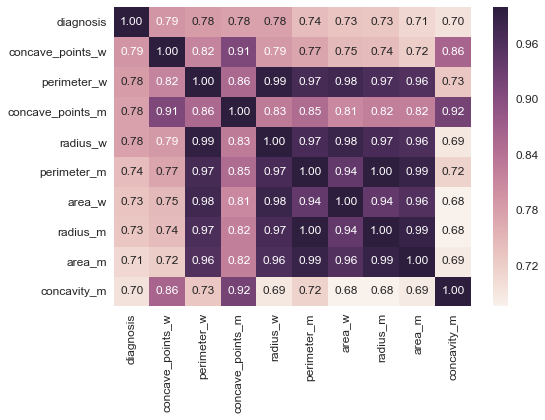

In [16]:
#plt.figure(figsize=(12,9))
sns.set(font_scale=1.2)
hm = sns.heatmap(cm, annot=True, fmt='.2f', annot_kws={'size': 12})

凹数や凹み具合、対象の周囲・半径・面積に相関があることが分かる。

### ペアプロット
相関係数上位10件の特徴量でペアプロット（散布図行列）作成

In [17]:
pair_df = df
# 相関係数上位10件の特徴量でデータフレーム作成
pair_df=pair_df.loc[:,corr_matrix_list]

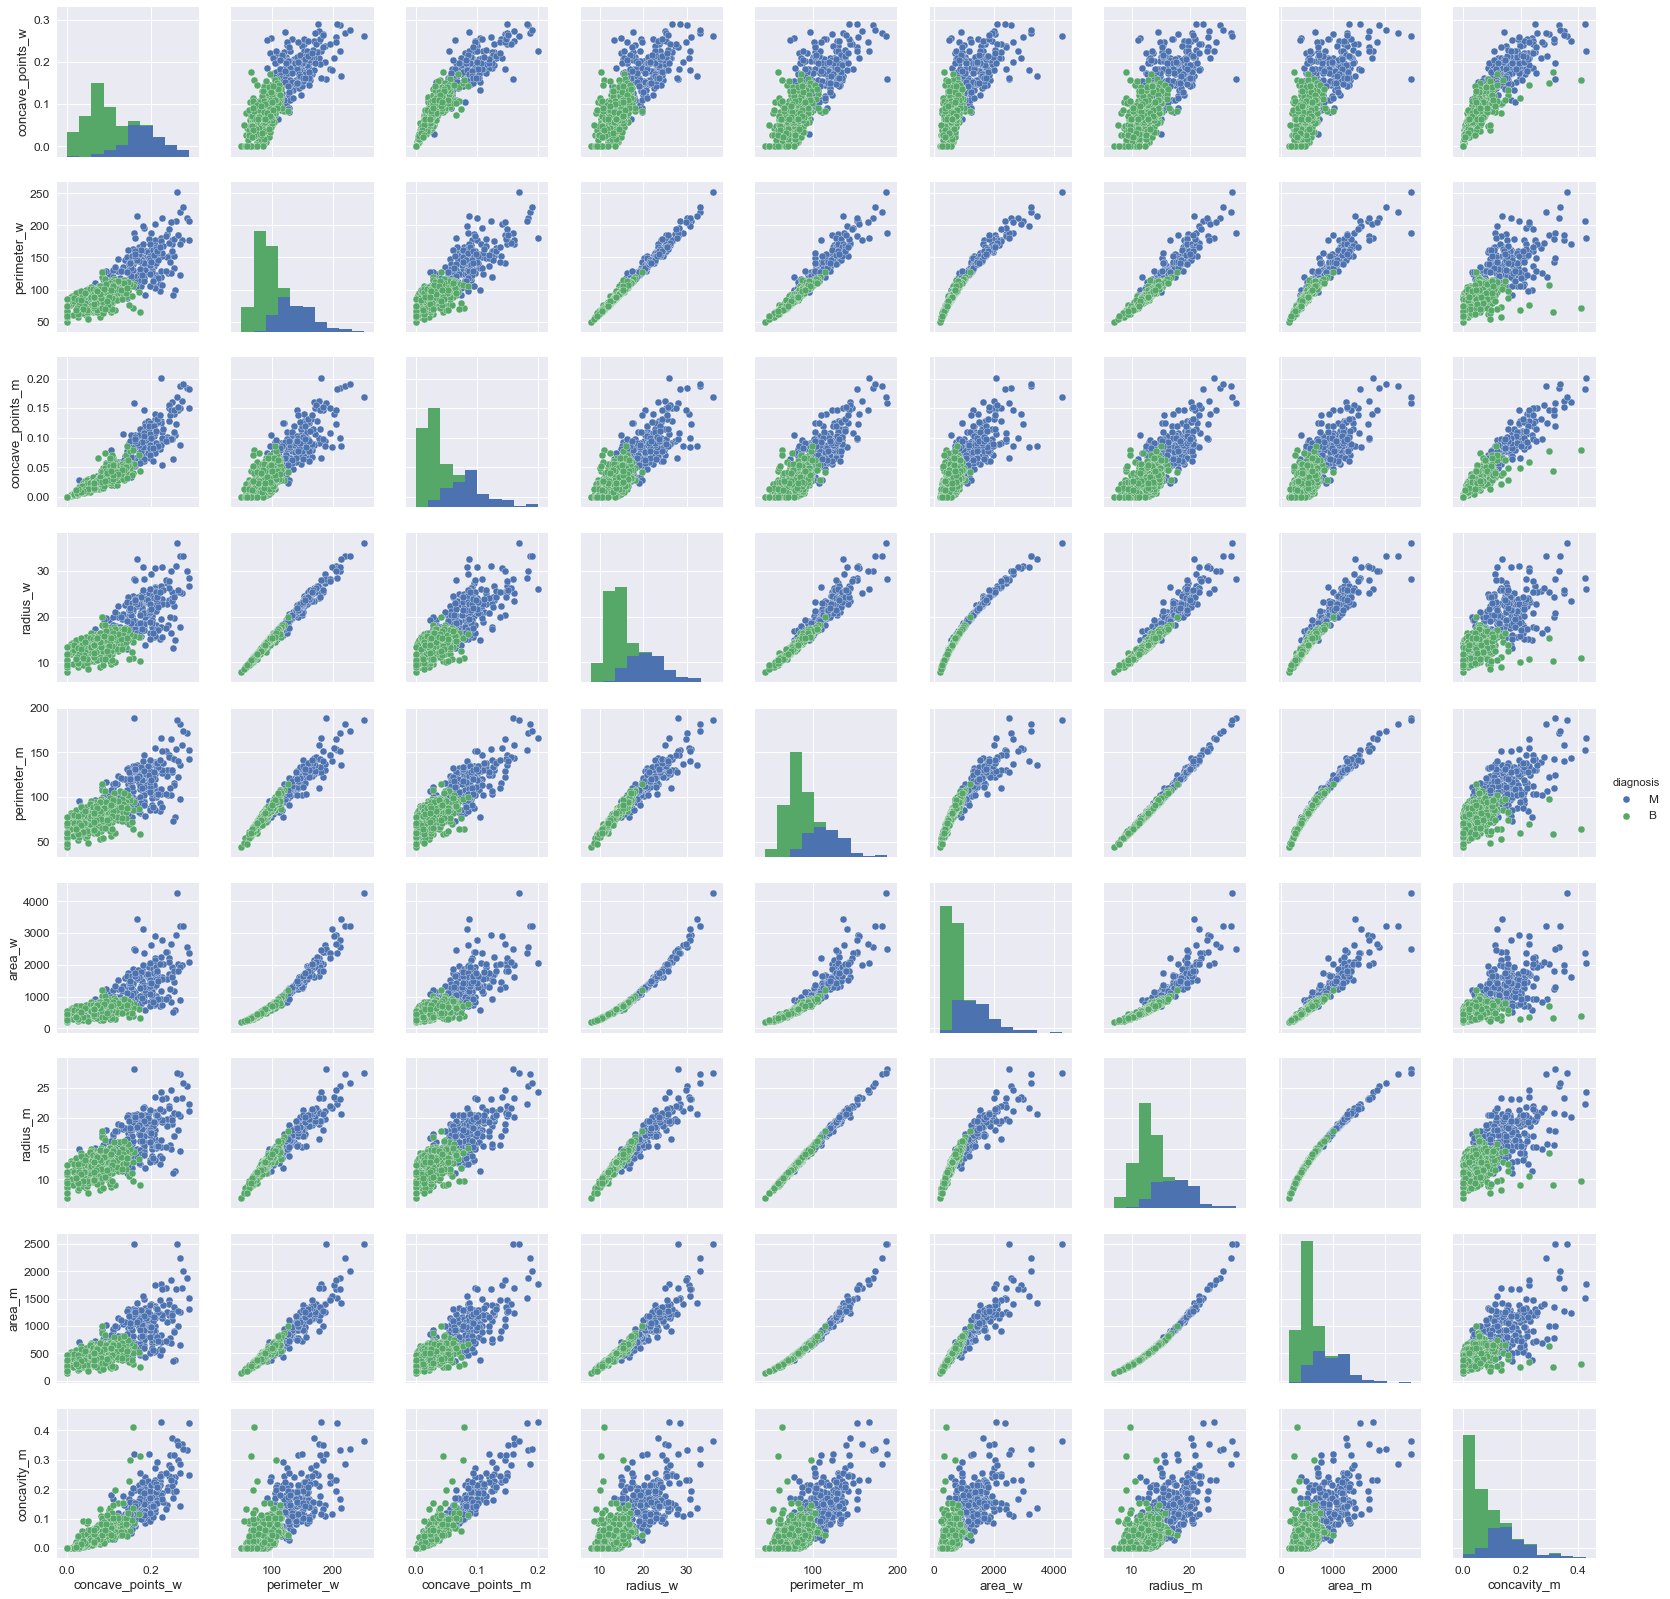

In [18]:
sns.pairplot(pair_df, hue='diagnosis')

どの特徴量も数値が高いほど、悪性の傾向があり、比較的容易に分類できそうなデータセットであることがわかる。

## 4. 前処理

In [19]:
# 目的変数
# カテゴリカルデータの数値化（良性を0、悪性を1にマッピング）
y = df.loc[:,("diagnosis")].map({'M': 1, 'B': 0})

In [20]:
# 説明変数
X=df.drop(["ID", "diagnosis"], axis=1)
# 標準化
X=(X - X.mean()) / np.std(X)
X.head()

,radius_m,texture_m,perimeter_m,area_m,smoothness_m,compactness_m,concavity_m,concave_points_m,symmetry_m,fractal_dimension_m,radius_s,texture_s,perimeter_s,area_s,smoothness_s,compactness_s,concavity_s,concave_points_s,symmetry_s,fractal_dimension_s,radius_w,texture_w,perimeter_w,area_w,smoothness_w,compactness_w,concavity_w,concave_points_w,symmetry_w,fractal_dimension_w
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,2.489734,-0.565265,2.833031,2.487578,-0.214002,1.316862,0.724026,0.660820,1.148757,0.907083,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,0.499255,-0.876244,0.263327,0.742402,-0.605351,-0.692926,-0.440780,0.260162,-0.805450,-0.099444,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,1.228676,-0.780083,0.850928,1.181336,-0.297005,0.814974,0.213076,1.424827,0.237036,0.293559,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,0.326373,-0.110409,0.286593,-0.288378,0.689702,2.744280,0.819518,1.115007,4.732680,2.047511,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,1.270543,-0.790244,1.273189,1.190357,1.483067,-0.048520,0.828471,1.144205,-0.361092,0.499328,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


## 5. データセットの分割

In [98]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [99]:
# X_train、X_testのデータ数をチェック
print("X_train：", len(X_train))
print("X_test：", len(X_test))

X_train： 455
X_test： 114


train と test が 8 : 2 に分割されている。

### stratifyについて

母集団の分布を良く維持してサンプリング。  
抽出元のサンプル数が少ない場合ほど、無作為サンプリングと比べてよい精度で抽出。

In [100]:
y_train.value_counts()

0    285
1    170
Name: diagnosis, dtype: int64

In [101]:
# y_train内のクラスラベル割合
print("0：",y_train.value_counts()[0]/len(y_train))
print("1：",y_train.value_counts()[1]/len(y_train))

0： 0.6263736263736264
1： 0.37362637362637363


In [102]:
y_test.value_counts()

0    72
1    42
Name: diagnosis, dtype: int64

In [103]:
# y_test内のクラスラベル割合
print("0：",y_test.value_counts()[0]/len(y_test))
print("1：",y_test.value_counts()[1]/len(y_test))

0： 0.631578947368421
1： 0.3684210526315789


ほぼ同様の分布で分割されている。

## 6. グリッドサーチ

- あらかじめ各パラメータの範囲(ex. 0,1,2,3,4,5など)を指定。
- 各範囲でモデルを交差検証し、精度を測定。
- 最適なパラメータを選出。

In [104]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svc = SVC(
    probability=True # 確率表示
)
param_grid = [
    { 'C': [1, 10, 100, 1000], 'kernel': ['linear'] },
    { 'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.001, 0.0001] },
    { 'C': [1, 10, 100, 1000], 'kernel': ['poly'], 'degree': [2, 3, 4], 'gamma': [0.001, 0.0001] },
    { 'C': [1, 10, 100, 1000], 'kernel': ['sigmoid'], 'gamma': [0.001, 0.0001] }
]

gs = GridSearchCV(
    estimator=svc, # 推定器
    param_grid=param_grid, # 最適化したいパラメータセット
    scoring="accuracy", # スコア
    cv=10, # k分割交差検証の回数
    n_jobs=-1, # CPU並列処理
    return_train_score=True, # トレインデータのスコアを出力
    verbose=0 # ログ・スコア非表示
) 

## 7. 学習

In [105]:
# 学習
gs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']}, {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.001, 0.0001]}, {'C': [1, 10, 100, 1000], 'kernel': ['poly'], 'degree': [2, 3, 4], 'gamma': [0.001, 0.0001]}, {'C': [1, 10, 100, 1000], 'kernel': ['sigmoid'], 'gamma': [0.001, 0.0001]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

### 交差検証結果

In [106]:
train_means = gs.cv_results_['mean_train_score']
train_stds = gs.cv_results_['std_train_score']
test_means = gs.cv_results_['mean_test_score']
test_stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']

for train_mean,train_std,test_mean,test_std,param in zip(train_means,train_stds,test_means,test_stds,params):
    print("train : {:.3f} (+/- {:.3f})".format(train_mean,train_std)," test : {:.3f} (+/- {:.3f})".format(test_mean,test_std)," param : ",param)
    print( '-'*100)

train : 0.988 (+/- 0.002)  test : 0.976 (+/- 0.021)  param :  {'C': 1, 'kernel': 'linear'}
----------------------------------------------------------------------------------------------------
train : 0.991 (+/- 0.002)  test : 0.965 (+/- 0.022)  param :  {'C': 10, 'kernel': 'linear'}
----------------------------------------------------------------------------------------------------
train : 0.997 (+/- 0.001)  test : 0.960 (+/- 0.026)  param :  {'C': 100, 'kernel': 'linear'}
----------------------------------------------------------------------------------------------------
train : 0.999 (+/- 0.001)  test : 0.954 (+/- 0.023)  param :  {'C': 1000, 'kernel': 'linear'}
----------------------------------------------------------------------------------------------------
train : 0.947 (+/- 0.003)  test : 0.945 (+/- 0.033)  param :  {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
train : 0.785 (+/- 0.

### 最適なパラメータとスコア出力

In [107]:
print("best_estimator_ : ",gs.best_estimator_)
print("best_params_ : ",gs.best_params_)
print("best_score_ : ",gs.best_score_)

best_estimator_ :  SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
best_params_ :  {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
best_score_ :  0.9846153846153847


## 8. 評価
下記評価を sklearn とスクラッチで、それぞれ求める。

- 混同行列指標
- Accuracy
- Recall
- Presicion
- F1-measure
- ROC曲線
- AUC

### 予測

In [108]:
# 確率
y_prob=gs.predict_proba(X_test)

In [109]:
# 予測値
y_pred = gs.predict(X_test)
y_pred

array([1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1])

### 混同行列作成
- 1：positive（悪性）
- 0：negative（良性）

In [110]:
from sklearn.metrics import confusion_matrix
labels=[1,0]
conf_mat=confusion_matrix(y_test, y_pred, labels)
#conf_mat=confusion_matrix(y_test, y_pred)
conf_mat

array([[40,  2],
       [ 1, 71]])

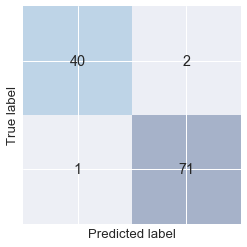

In [111]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')
        ax.tick_params(labeltop=False, labelleft=False) # 軸の削除

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.show()

### 混同行列指標

In [112]:
# sklearn
(tp, fn, fp, tn) = confusion_matrix(y_test, y_pred, labels).ravel()

In [113]:
print("真陽性：",tp)
print("偽陰性：",fn)
print("偽陽性：",fp)
print("真陰性：",tn)

真陽性： 40
偽陰性： 2
偽陽性： 1
真陰性： 71


In [114]:
# スクラッチ
test=y_test.reset_index().drop("index", axis=1).rename(columns={"diagnosis":"test"})
pred=pd.DataFrame(y_pred).rename(columns={0:"pred"})
pred_test=pd.concat([pred, test], axis=1)

In [115]:
TP=len(pred_test[(pred_test['pred'] == 1) & (pred_test['test'] == 1)])
FN=len(pred_test[(pred_test['pred'] == 0) & (pred_test['test'] == 1)])
FP=len(pred_test[(pred_test['pred'] == 1) & (pred_test['test'] == 0)])
TN=len(pred_test[(pred_test['pred'] == 0) & (pred_test['test'] == 0)])

In [116]:
print("真陽性：",TP)
print("偽陰性：",FN)
print("偽陽性：",FP)
print("真陰性：",TN)

真陽性： 40
偽陰性： 2
偽陽性： 1
真陰性： 71


### Accuracy

In [117]:
# sklearn
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9736842105263158

In [118]:
# スクラッチ
accuracy = (TP + TN) / (TP + TN + FP + FN)
accuracy

0.9736842105263158

### Recall（再現率）

In [119]:
# sklearn
from sklearn.metrics import recall_score
recall_score(y_test, y_pred)

0.9523809523809523

In [120]:
# スクラッチ
recall = TP / (TP + FN)
recall

0.9523809523809523

### Precision（適合率）

In [121]:
# sklearn
from sklearn.metrics import precision_score
precision_score(y_test, y_pred)

0.975609756097561

In [122]:
# スクラッチ
precision = TP / (TP + FP)
precision 

0.975609756097561

### F1-measure

In [123]:
# sklearn
from sklearn.metrics import f1_score
f1_score(y_test, y_pred) 

0.963855421686747

In [124]:
# スクラッチ
f1 = 2 * (precision * recall) / (precision + recall)
f1

0.963855421686747

### ROC曲線

- ROC（Receiver Operating Characteristic：受信者動作特性）
- 閾値ごとに算出される真陽性率（TPR）と偽陽性率（FPR）をプロットした曲線
- ROC対角線は当て推量（ランダム推定）として解釈でき、下回る分類モデルは当て推量よりも劣る、または意図的に間違えているとみなされる。
- 精度が高い分類モデルであればあるほど、左上隅に位置づけられる（ベストは、FPRが0のとき、TPRが1）

** 真陽性率 **  
- Trueデータに対して、Positiveと予測した割合：TP /（TP + FN）  
- Recall（再現率）や感度と同じ

** 偽陽性率 **  
- Trueデータに対して、Positiveと予測した割合：TP /（TP + FN）  
- 1 - 特異度：FN /（TP + FN）と同じ


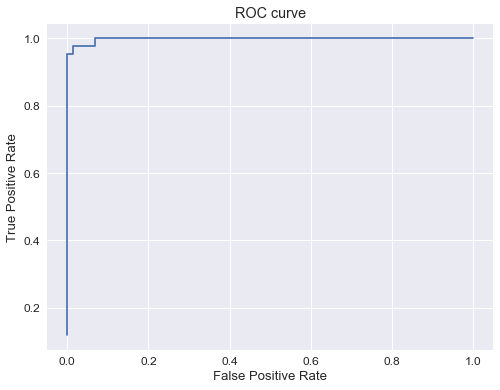

In [139]:
# sklearn
from sklearn.metrics import roc_curve
from sklearn.svm import SVC

fpr, tpr, thresholds= roc_curve(y_test, y_prob[:,1])

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

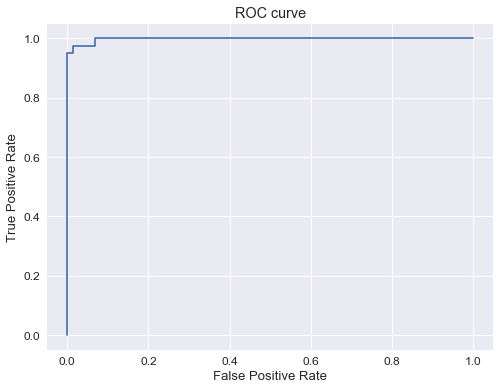

In [137]:
# スクラッチ
x=np.arange(101)/100 # 閾値
true_rate=[] # 真陽性率
false_rate=[] # 偽陽性率

for i in range(101):
    pred=pd.DataFrame((y_prob[:,1]>x[i]).astype(int)).rename(columns={0:"pred"})
    pred_test=pd.concat([pred,test], axis=1)
    tp=sum((pred_test["pred"]==1)&(pred_test["test"]==1))
    fn=sum((pred_test["pred"]==0)&(pred_test["test"]==1))
    fp=sum((pred_test["pred"]==1)&(pred_test["test"]==0))
    tn=sum((pred_test["pred"]==0)&(pred_test["test"]==0))
    true_rate.append(tp/(tp+fn))
    false_rate.append(fp/(fp+tn))

plt.figure(figsize=(8,6))
plt.plot(false_rate,true_rate)
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

 ### AUC
 
 - AUC（Area Under the Curve）
 - ROC曲線を積分し、精度を数値化

In [140]:
# sklearn
auc = np.trapz(tpr,fpr)
print('AUC：'+str(auc))

AUC：0.998015873015873


In [141]:
# スクラッチ
h=np.array([true_rate])[0]
w=np.array([false_rate])[0]

area=0
for i in range(100):
    area+=h[i]*(w[i]-w[i+1])
print('AUC：'+str(area))

AUC：0.998015873015873


## 9. クラス化

In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve

class SvmModel():
    
    def __init__(self):
        pass

    def model_tuning(self, X_train, y_train, tuned_parameters, scoring, cv):  
        gs = GridSearchCV(
            estimator = SVC(probability = True),
            param_grid = tuned_parameters,
            scoring = scoring,
            cv = cv,
            n_jobs=-1,
            return_train_score=True,
            verbose=0
        )
        gs.fit(X_train, y_train)
        return gs, gs.best_params_
    
    def evaluation(self, X_test, y_test, gs):
        y_pred = gs.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        return accuracy, recall, precision
    
    def roc_curve_auc(self, X_test, y_test, gs):
        prob = gs.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, prob)

        plt.figure(figsize = (8,6))
        plt.plot(fpr, tpr)
        plt.title("ROC curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.show()
        
        auc = np.trapz(tpr, fpr)
        return auc

### 動作確認

In [235]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [236]:
tuned_parameters = [
    { 'C': [1, 10, 100, 1000], 'kernel': ['linear'] },
    { 'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.001, 0.0001] },
    { 'C': [1, 10, 100, 1000], 'kernel': ['poly'], 'degree': [2, 3, 4], 'gamma': [0.001, 0.0001] },
    { 'C': [1, 10, 100, 1000], 'kernel': ['sigmoid'], 'gamma': [0.001, 0.0001] }
]

In [237]:
# SvmModelクラスからオブジェクト作成
sm = SvmModel()

In [238]:
# パラメーターチューニング
gs,best_params = sm.model_tuning(X_train, y_train, tuned_parameters, "accuracy", 10)
print("best_parameters："+ str(best_params))

best_parameters：{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [239]:
# モデル評価
accuracy, recall, precision = sm.evaluation(X_test, y_test, gs)
print("accuracy："+ str(accuracy))
print("recall："+ str(recall))
print("precision："+ str(precision))

accuracy：0.9736842105263158
recall：0.9523809523809523
precision：0.975609756097561


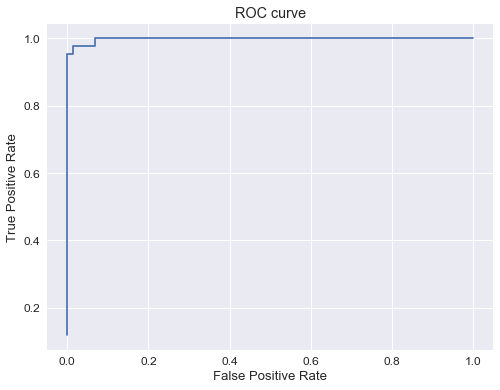

In [151]:
# ROC曲線
auc = sm.roc_curve_auc(X_test, y_test, clf)

In [240]:
# AUC
print("AUC：" + str(auc))

AUC：0.998015873015873


正常に動作していることを確認

## 10. 今後の課題
- カーネルやパラメータなど、SVMの深掘り（AIF_sprint-4-SVM参照）
- SVMをスクラッチで実装（ https://qiita.com/ta-ka/items/e6fd0b6fc46dbab4a651 ）